<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Assignment-Prompt" data-toc-modified-id="Assignment-Prompt-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Assignment Prompt</a></span><ul class="toc-item"><li><span><a href="#Import-and-Visualize-the-Training-and-Test-Data" data-toc-modified-id="Import-and-Visualize-the-Training-and-Test-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import and Visualize the Training and Test Data</a></span></li><li><span><a href="#Grading-Criteria" data-toc-modified-id="Grading-Criteria-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Grading Criteria</a></span></li><li><span><a href="#Grading-Rubric" data-toc-modified-id="Grading-Rubric-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Grading Rubric</a></span></li></ul></li><li><span><a href="#Analysis-Approach" data-toc-modified-id="Analysis-Approach-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis Approach</a></span></li><li><span><a href="#Basic-Trends/Exploratory-Analysis" data-toc-modified-id="Basic-Trends/Exploratory-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic Trends/Exploratory Analysis</a></span></li><li><span><a href="#Kernel-Structure" data-toc-modified-id="Kernel-Structure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Kernel Structure</a></span><ul class="toc-item"><li><span><a href="#Kernel-Contributions" data-toc-modified-id="Kernel-Contributions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Kernel Contributions</a></span></li><li><span><a href="#Final-Kernel" data-toc-modified-id="Final-Kernel-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Final Kernel</a></span></li></ul></li><li><span><a href="#Fitting-of-Kernel-Hyperparameters" data-toc-modified-id="Fitting-of-Kernel-Hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting of Kernel Hyperparameters</a></span><ul class="toc-item"><li><span><a href="#MAP-Hyperparameter-Inference" data-toc-modified-id="MAP-Hyperparameter-Inference-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>MAP Hyperparameter Inference</a></span><ul class="toc-item"><li><span><a href="#The-MAP-approach" data-toc-modified-id="The-MAP-approach-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>The MAP approach</a></span></li><li><span><a href="#Gradient-Descent-Method" data-toc-modified-id="Gradient-Descent-Method-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Gradient Descent Method</a></span></li><li><span><a href="#MAP-implementation" data-toc-modified-id="MAP-implementation-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>MAP implementation</a></span></li></ul></li></ul></li><li><span><a href="#Posterior-predictive-Distribution" data-toc-modified-id="Posterior-predictive-Distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Posterior predictive Distribution</a></span><ul class="toc-item"><li><span><a href="#Final-Plot" data-toc-modified-id="Final-Plot-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Final Plot</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Begin-Coding" data-toc-modified-id="Begin-Coding-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Begin Coding</a></span></li></ul></div>

# Building Your Own Gaussian Process Model

Due Date: March 15th, 2024 | 21:00 on Canvas

## Assignment Prompt

Based off of the Mauna Loa CO2 dataset.

Per the assignment prompt:

"This assignment requires you to fit a Gaussian process model to the Mauna Loa data set. It is a univariate dataset that comprises the monthly average carbon dioxide concentration, measured in parts per million.

You will find the data at this [site](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). You will have to download the `monthly_in_situ_co2_mlo.csv` file directly. Details about the data can be found in reference 1.

The plot below shows the data: year vs. CO2 (ppm). Some rows of the table have -99.99 values; these may be ignored. Note that as there are 12 measurements per year (1 for each month), utilizing just the year as the covariate is not appropriate, and that is why the “Date” or third column must be used.

Your training data must be limited to all years before 2014, i.e., you may only use CO2 concentrations in the years 1958 to 2013. It is entirely your decision whether you wish to use all this data, or select a subset."

### Import and Visualize the Training and Test Data

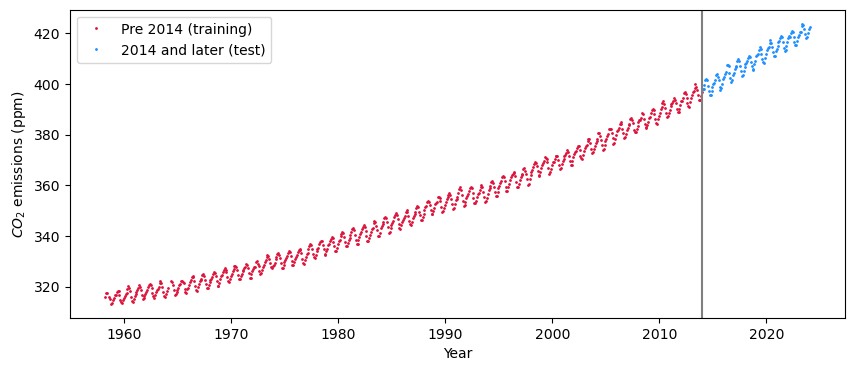

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read in and clean the data:
df = pd.read_csv('monthly_in_situ_co2_mlo.csv',skiprows=64,header=None)
df.drop([0,1,2,5,6,7,8,9,10],axis=1,inplace=True)
df.columns = ["Date","CO2"]
df = df[df['CO2']> 0]

# visualize training vs test data
df2014 = df[df['Date']< 2014]
dfnew = df[df['Date']>= 2014]

fig = plt.figure(figsize=(10,4))
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.show()

### Grading Criteria

- Appropriate importing of the data and filtering of non-relevant rows. I will run your code on the “.csv” file as provided on the Scripps website. You cannot submit your amended version of the data.
- Use of multiple kernel functions, justifying what exactly each kernel is doing.
- A well-documented Jupyter notebook with equations for all the relevant formulas and code. If your code does not run, or produces an error upon running, you will loose a lot of marks.
- One approach for hyperparameter inference (e.g., maximum likelihood, cross validation, Markov chain Monte Carlo, etc.). Please note that the signal noise need not be optimized over (but can be if you wish).
- You will have to analytically calculate any gradients for hyperparameter inference. To clarify, code that does not use gradients, or code where the gradients are incorrect, will not receive full marks. To check your gradients you can always use finite differences.
- You are restricted to the following libraries: numpy, seaborn, matplotlib, scipy, pandas. Thus, you will have to build a lot of the codebase yourself.
- The last plot in your submission should have the same data as the plot above (both pre- and post-), along with predictive posterior mean and standard deviation contours.

### Grading Rubric

- Data importing [5]
- GP model architecture (i.e. kernels) [5]
- Hyperparameter inference [10]
- Clarity of documentation [5]

## Analysis Approach

1. Show the basics of finding the mean and covariance of a function at new values of Xnew, given y,X,Xnew. i.e. $f_* | y,X,X_{new}$.
    - This involves a Gaussian conditional.
    - Harken back to what kernels mean - they are functions that define the underlying basis functions that describe how the weights impact the measurement.
2. We have to however, choose hyperparameters for the kernels, they are not immediately given
    - SE kernel as an example
    - Using MAP (Maximum a posteriori) estimation of the hyperparameters
        - essentially finding the hyperparameters that lead to the maximum of $p(y|X,\theta)$ 
        - drawback is that it is it could converge on a local maximum
    - MCMC is another method I will use if I have time
        - gives the full distribution of $p(y|X,\theta)$ over the hyperparameters *numerically*, from which we can draw samples.
3. Once we have chosen our hyperparameters, we plug into the conditional Gaussian Process equation for f* and solve for the mean and covariance.
    - to visualize the capability of the predictions, we draw samples from f*'s multivariate Guassian distribution and plot the results to compare with the test data

## Basic Trends/Exploratory Analysis

Talk about/plot a few basic trends:

1. Major trend
2. Seasonal (yearl) trend
3. Medium term irregularities
4. Short-term noise
5. Measurement noise

## Kernel Structure

### Kernel Contributions

In this section we describe the kernels that are chosen to model the four basic trends described in the previous section. The kernels and the reasoning are effectively copied from Rasmussen & Williams book, Gaussian Process for Machine Learning [7].

1. Major trend.
    - The major trend here is a long term, smoothly rising trend in the atmospheric CO2 concentration level. To model this, we choose a Squared Exponential function, which if the parameters are learned correctly (correct amplitude and length scale), will pick up the smooth trend in the data.

$$k_1 (x,x') = \theta_1 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_2 ^2} \right) $$
    
2. Seasonal (yearly) trend.
    - Rasmussen and Williams talk about how the seasonal growth and decay of plant matter contributes to the atmospheric CO2 in the Mauna Loa region. Based on the plots shown above, we can see that they have a very consistent yearly periodic trend. However, it appears that the trend is not perfect, so a squared exponential term is multiplied with the periodic term. This effectively introduces a decay of the periodic impacts on the prediction. If $\theta_4$ turns out to be very large after fitting the hyperparameters, then the decay term will not have a big effect on the periodic trend.
    - In the expression below, note that the periodic term is defined to have a constant period of 1 year.

$$k_2 (x,x') = \theta_3 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_4 ^2} - \frac{2 \sin^2 \left(\pi(x-x')\right)}{\theta_5 ^2} \right)$$

3. Medium term irregularities.
    - In the model we can see that the CO2 concentration peaks higher in some years than the year following, such as in ~1992 and ~2000. To model irregularities like this, we introduce a rational quadratic term, as recommended by Rasmussen and Williams. In their analysis, the rational quadratic kernel performed better than the simpler squared exponential kernel. They explain this is likely due to the rational quadratic kernel representing a bunch of squared-exponential length-scales.

$$k_3 (x,x') = \theta_6 ^2 \left(1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8} \right)^{-\theta_8} $$

4. Short-term noise.
    - To model the short-term noise, we choose a squared-exponential kernel. We will expect the amplitude and length scale of this kernel to end up relatively small compared to the amplitudes of the Major, Seasonal and Medium trend amplitudes.
    
$$k_4 (x,x') = \theta_9 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_{10}^2} \right) $$

5. Measurement noise.
    - Finally, we model the measurement noise. This is independent noise added to accomodate noise in the measurement instruments.
    
$$k_5 (x_p, x_q) = \theta_{11}^2 \delta_{pq}$$

$$\Rightarrow K_5 = \theta_{11}^2 I_n,\ \text{where}\ n=\text{# of training data points}$$


In [148]:
def tiled_difference(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(1,n)
    X = np.tile(xa,(1,n)) - np.tile(xb,(m,1))
    return X

def K1(x,xp,th1,th2):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th1**2 * np.exp(-(xdiff)**2 / (2* th2**2))
    return K

def K2(x,xp,th3,th4,th5):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th3**2 * np.exp(-(xdiff)**2 / (2* th4**2) \
                           - 2* np.sin(np.pi * (xdiff))**2/(th5**2))
    return K

def K3(x,xp,th6,th7,th8):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th6**2 * (1 + (xdiff)**2 / (2* th7**2 * th8))**(-th8)
    return K

def K4(x,xp,th9,th10):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th9**2 * np.exp(-(xdiff)**2 / (2* th10**2))
    return K

def K5(x,xp,th11):
    K = tiled_difference(x.astype(float),xp.astype(float))
    K[np.where(K!=0)] = 2
    K[np.where(K==0)] = 1
    K[np.where(K!=1)] = 0
    return th11**2 * K

### Final Kernel

The final kernel is computed as the sum of the previous five kernel functions:

$$k(x,x') = k_1(x,x') + k_2(x,x') + k_3(x,x') + k_4(x,x') + k_5(x,x')$$

In [149]:
def kernel(x,xp,theta):
    if theta.shape != (11,):
        raise AttributeError('Theta vector is not the correct shape. Must be (11,)')
    
    kern1 = K1(x,xp,theta[0],theta[1])
    kern2 = K2(x,xp,theta[2],theta[3],theta[4])
    kern3 = K3(x,xp,theta[5],theta[6],theta[7])
    kern4 = K4(x,xp,theta[8],theta[9])
    kern5 = K5(x,xp,theta[10])
    k = kern1 + kern2 + kern3 + kern4 + kern5
    
    return k

## Fitting of Kernel Hyperparameters

### MAP Hyperparameter Inference

layout the MAP equations and what we're going after.
show the partial derivatives of the kernel functions
explain how we're going to do the gradient descent for a multi-function non-linear problem, with notes on how to simplify the math that we're doing, since K is a positive definite matrix.

#### The MAP approach

In the maximum a posterior (MAP) hyperparameter inference technique, the goal is to find the most likely hyperparameters, given the measurements we have:

$$p(\theta|t) = \frac{p(t|\theta) p(\theta)}{p(t)}$$

Since the marginal likelihood $p(t) = \int p(t|\theta) p(\theta) d\theta$ is usually intractable, we look instead at an approximation of $p(\theta|t)$, noting that $p(t)$ is constant with respect to $\theta$. [9]

$$p(\theta|t) = \frac{p(t|\theta) p(\theta)}{p(t)} \propto p(t|\theta) p(\theta)$$

Now, we can find the maximum of $p(\theta|t)$ by investigating $\log p(\theta|t)$ and maximizing the result w.r.t. $\theta$. This is by definition the MAP estimate: [9]

$$\hat{\theta}_{MAP} = \underset{\theta}{argmax} \log{p(\theta|t)}= \underset{\theta}{argmax} \log{p(t|\theta)} + \log{p(\theta)}$$

where $p(\theta)$ is the prior of $\theta$ defined by the user.

Now, since we know that $p(t|\theta) \sim \mathcal{N}(t|0, C(\theta) + \sigma^2 I_N)$, we can write: [9]

$
\begin{align}
\log{p(t|\theta)} &= \log{\left[ (2 \pi)^{-N/2} |C + \sigma^2 I|^{-1/2} \exp \left( -\frac{1}{2} t^T (C + \sigma^2 I)^{-1} t \right) \right]} \\
&= -\frac{N}{2} \log{(2\pi)} -\frac{1}{2} \log{|C + \sigma^2 I|} - \frac{1}{2} t^T (C + \sigma^2 I)^{-1} t \\
&= -\frac{N}{2} \log{(2\pi)} -\sum_{i=1}^N \log{\mathbf{L}_{ii}} - \frac{1}{2} a^T a
\end{align}
$

where $S = C + \sigma^2 I = LL^T$ (Cholesky decomposition of a PD matrix) and $t^T S^{-1} t = t^T L^{-T}L^{-1} t = (L^{-1}t)^T(L^{-1}t) = a^T a$.

<br>

To investigate $\underset{\theta}{argmax} \log{p(\theta|t)}$, we note that we want values of $\theta$ where $\nabla_{\theta} \log{p(\theta|t)} = 0$ and $\log{p(\theta|t)}$ is large, i.e. we have a local maximum. To compute this, we will use a gradient descent method.

<br>

For now, we assume that $p(\theta)$ is a uniform distribution such that $\log{p(\theta)}$ is constant and we have: [9]

$\begin{align}
\hat{\theta}_{MAP} &= \underset{\theta}{argmax} \log{p(\theta|t)}= \underset{\theta}{argmax} \log{p(t|\theta)} + \log{constant} \\
&\propto \underset{\theta}{argmax} \log{p(t|\theta)}
\end{align}$

Thus we only have to investigate the gradient descent of $\nabla_{\theta} \log{p(t|\theta)}$.

#### Gradient Descent Method

In Rasmussen & Williams' book, they have provided the equation for the partial derivative of $\log{p(t|\theta)}$ w.r.t. each hyperparameter $\theta_j$, shown below: [10]

$$\frac{\partial}{\partial \theta_j} \log{p(y|X,\theta)} = \frac{1}{2} y^T K^{-1} \frac{\partial K}{\partial\theta_j} K^{-1} y - \frac{1}{2} tr\left(K^{-1} \frac{\partial K}{\partial\theta_j} \right) \\
= \frac{1}{2} tr\left( (\alpha \alpha^T - K^{-1}) \frac{\partial K}{\partial\theta_j} \right)$$

where $y = t$, $\alpha = K^{-1} y$ and $K = K(x,x')$, the kernel. Note that Rasmussen and Williams explicitly include X since it is necessary for computation of the kernel.

If we define the function $G(\theta)$ as:

$$G(\theta) = \left[\nabla_{\theta} \log{p(t|\theta)}\right]^T$$

and we define $F(\theta)$ as:

$$F(\theta) = \frac{1}{2} G(\theta)^T G(\theta)$$

Then we can take $F(\theta)$ to be our optimization function. [2]

$F(\theta)$ is both a scalar function which is easier to minimize, and also squares the gradient components contained in $G(\theta)$, ensuring $F(\theta) \ge 0\ \forall\ \theta$. Thus, now our goal will be to minimize $F(\theta)$ w.r.t. $\theta$, and ideally find values of $\theta$ s.t. $F(\theta) =0$.



#### MAP implementation

In order to compute $G(\theta)$ and $F(\theta)$, we need a closed form representation of $\frac{\partial}{\partial \theta_j} \log{p(y|X,\theta)}$, which in turn relies on having a closed form solution of $\frac{\partial K}{\partial\theta_j}$. With regards to the latter, we have, for each element of the matrix $\frac{\partial K}{\partial\theta_j}$:

$
\begin{align}
\frac{\partial k(x,x')}{\partial\theta_1} &= 
        2 \theta_1 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_2 ^2}\right) \\
\frac{\partial k(x,x')}{\partial\theta_2} &= 
        \theta_1 ^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_2 ^2}\right)
            \left( \frac{(x-x')^2}{\theta_2 ^3} \right) \\
\frac{\partial k(x,x')}{\partial\theta_3} &= 
        2 \theta_3 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_4 ^2} - 
            \frac{2 \sin^2\left(\pi(x-x')\right)}{\theta_5^2}\right) \\
\frac{\partial k(x,x')}{\partial\theta_4} &= 
        \theta_3^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_4 ^2} - 
            \frac{2 \sin^2\left(\pi(x-x')\right)}{\theta_5^2}\right) 
            \left( \frac{(x-x')^2}{\theta_4 ^3} \right)\\
\frac{\partial k(x,x')}{\partial\theta_5} &= 
        \theta_3^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_4 ^2} - 
            \frac{2 \sin^2\left(\pi(x-x')\right)}{\theta_5^2}\right) 
            \left( \frac{4 \sin^2\left(\pi(x-x')\right)}{\theta_5^3} \right)\\
\frac{\partial k(x,x')}{\partial\theta_6} &= 
        2 \theta_6 \left( 1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8}\right)^{-\theta_8} \\
\frac{\partial k(x,x')}{\partial\theta_7} &= 
        \theta_6^2 \left( 1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8}\right)^{-\theta_8 - 1}
            \left( \frac{(x-x')^2}{\theta_7 ^3} \right)\\
\frac{\partial k(x,x')}{\partial\theta_8} &= 
        \theta_6^2 \left( 1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8}\right)^{-\theta_8}
            \left( \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8 + (x-x')^2} - 
            \log{\left(1 + \frac{(x-x')^2}{1 \theta_7 ^2 \theta_8}\right)} \right)\\
\frac{\partial k(x,x')}{\partial\theta_9} &= 
        2 \theta_9 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_{10} ^2}\right) \\
\frac{\partial k(x,x')}{\partial\theta_{10}} &= 
        \theta_9^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_{10} ^2}\right) 
            \left( \frac{(x-x')^2}{\theta_{10} ^3} \right) \\
\frac{\partial k(x,x')}{\partial\theta_{11}} &= 
        2 \theta_{11} \delta_{pq}
\end{align}
$

**TO DO, may not need the statements below... if no computational savings gained.**

We note that since we are computing the **trace** of a matrix, we only need the diagonal terms. 

Since K is a PD matrix, $\exists$ a diagonal matrix D of the eigenvalues, whose diagonal entries are non-zero, such that $K = VDV^{-1}$ where V is the eigen-vector matrix. Now since $K^{-1} = VD^{-1}V^{-1}$, we have that $tr(K^{-1}) = tr(D^{-1})$. [4]

Thus, for $K^{-1}$ we only have to find the eigen values of K, and then can compute $D^{-1}$ as the inverses of the eigen-values.

Reminding ourselves what we are trying to capture (where $\alpha = K^{-1} y$ and $K = K(x,x')$, the kernel):

$$\frac{\partial}{\partial \theta_j} \log{p(y|X,\theta)} = \frac{1}{2} y^T K^{-1} \frac{\partial K}{\partial\theta_j} K^{-1} y - \frac{1}{2} tr\left(K^{-1} \frac{\partial K}{\partial\theta_j} \right) \\
= \frac{1}{2} tr\left( (\alpha \alpha^T - K^{-1}) \frac{\partial K}{\partial\theta_j} \right)$$

and 

$$G(\theta) = \left[\nabla_{\theta} \log{p(t|\theta)}\right]^T$$

We can start developing our computations:

Using a similar setup for the partial derivative kernels as developed in Section "Kernel Contributions", we have:

In [148]:
# defining the partial derivative matrices:

# TO DO: actually implement the partial derivatives

def Kpartial1(x,xp,theta,i):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    if i == 0:
        Kpartial = theta[0]**2 * np.exp(-(xdiff)**2 / (2* theta[1]**2))
    elif i == 1:
        Kpartial = theta[0]**2 * np.exp(-(xdiff)**2 / (2* theta[1]**2))
    elif i == 2:
        Kpartial = theta[2]**2 * np.exp(-(xdiff)**2 / (2* theta[3]**2) \
                           - 2* np.sin(np.pi * (xdiff))**2/(theta[4]**2))
    elif i == 3:
        Kpartial = theta[2]**2 * np.exp(-(xdiff)**2 / (2* theta[3]**2) \
                           - 2* np.sin(np.pi * (xdiff))**2/(theta[4]**2))
    elif i == 4:
        Kpartial = theta[2]**2 * np.exp(-(xdiff)**2 / (2* theta[3]**2) \
                           - 2* np.sin(np.pi * (xdiff))**2/(theta[4]**2))
    elif i == 5:
        Kpartial = theta[5]**2 * (1 + (xdiff)**2 / (2* theta[6]**2 * theta[7]))**(-theta[7])
    elif i == 6:
        Kpartial = theta[5]**2 * (1 + (xdiff)**2 / (2* theta[6]**2 * theta[7]))**(-theta[7])
    elif i == 7:
        Kpartial = theta[5]**2 * (1 + (xdiff)**2 / (2* theta[6]**2 * theta[7]))**(-theta[7])
    elif i == 8:
        Kpartial = theta[8]**2 * np.exp(-(xdiff)**2 / (2* theta[9]**2))
    elif i == 9:
        Kpartial = theta[8]**2 * np.exp(-(xdiff)**2 / (2* theta[9]**2))
    elif i == 10:
        Kpartial = xdiff
        Kpartial[np.where(Kpartial!=0)] = 2
        Kpartial[np.where(Kpartial==0)] = 1
        Kpartial[np.where(Kpartial!=1)] = 0
        Kpartial = theta[10]**2 * Kpartial
    else:
        raise AttributeError('i must be in range 0-10')
    
    return Kpartial

# define G(theta)

def G(x,xp,theta):
    # compute alpha = K^-1 y
    # compute alpha*alpha^T + K^-1
    # initialize vector G of same size as theta^T
    # for each theta_i
        # compute 1/2*trace((alpha*alpha^T + K^-1) dK/dth_i)
        
        # assign to G[i]
        
# define F(theta) - should it be a lambda function?

# compute the optimization using scipy.optimize.minimize

# repeat for several initial values of theta and save into a list/array of potential sets of theta

# compute the log p(y|X,theta) for each set, and choose the set that leads to the maximum probability

## Posterior predictive Distribution

Code to calculate the posterior predictive distribution. Using RW pg 19 as a reference for the algorithm.

In [169]:
def posterior_predictive(x,y,xnew,theta):
    # condition the inputs
    x = x.values
    y = y.values
    xnew = xnew.values
    # compute the mean and covariance
    Kxx = kernel(x,x,theta)
        # check if all the eigen values of the kernel are > 0
    if np.all(np.linalg.eigvals(Kxx) > 0) == False:
        print('eigen values were not > 0')
        m,n = Kxx.shape # should be square...
        Kxx = Kxx + 1e-9*np.eye(m,m) # adding a small value to deal with floating point errors
    L = np.linalg.cholesky(Kxx)
    alpha = np.linalg.inv(L.T) @ np.linalg.inv(L) @ y
    mean = kernel(xnew,x,theta) @ alpha
    v = np.linalg.inv(L) @ kernel(x,xnew,theta)
    # finally, compute covariance with added measurement noise
    cov = kernel(xnew,xnew,theta) - v.T @ v + K5(xnew,xnew,theta[10])
    n = len(y)
    marginal = -1/2 * y.T @ alpha - np.sum(np.log(np.diag(L))) - n/2 * np.log(2*np.pi)
    return mean, cov, marginal

First let's try it with the RW parameters! Since we have the same kernel.

<function matplotlib.pyplot.show(close=None, block=None)>

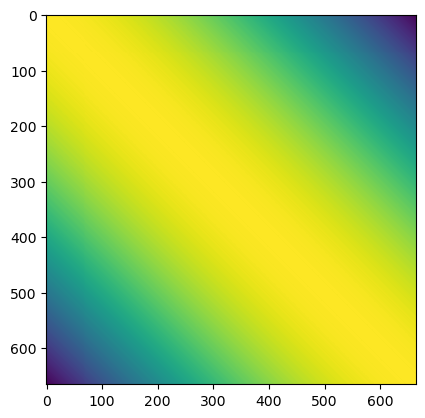

In [181]:
# using parameters from RW:
theta = np.array([66, 67, 2.4, 90, 1.3, 0.66, 1.2, 0.78, 0.18, 1.6/12, 0.19]).reshape((11))

x = df2014['Date']
Kxx = kernel(x,x,theta)

plt.imshow(Kxx)
plt.show

In [170]:
x = df2014['Date']
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'] - mu_y # centering values for better analysis
xnew = dfnew['Date']
mu, cov, marg_like = posterior_predictive(x,y,xnew,theta)

<function matplotlib.pyplot.show(close=None, block=None)>

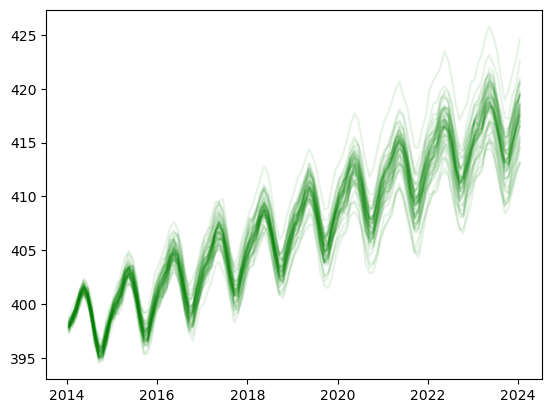

In [179]:
# generate 50 new posterior predictive predictions
fstar = np.random.multivariate_normal(mu,cov,50) + mu_y

fig = plt.figure(figsize=(8,4))
plt.plot(xnew,fstar.T,'g',alpha=0.1)
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.legend()
plt.title('Random draws from the Posterior Predictive using RW parameters')
plt.show

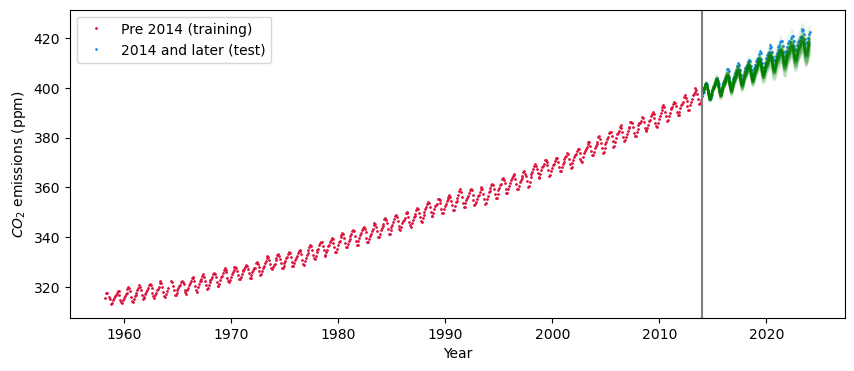

In [180]:
fig = plt.figure(figsize=(10,4))
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.plot(xnew,fstar.T,'g',alpha=0.1)
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Random draws from the Posterior Predictive using RW parameters')
plt.show()

### Final Plot

Plot, using training data, test data, and posterior predictive samples. Zoom in on the test region. If possible, identify a parameter to indicate how accurate my predictions are... Mean Squared Error?

<function matplotlib.pyplot.show(close=None, block=None)>

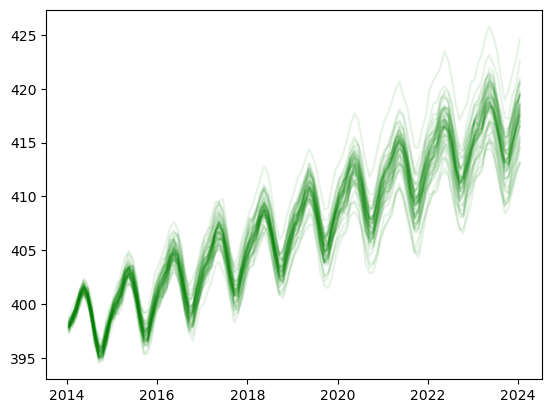

In [179]:
fstar = np.random.multivariate_normal(mu,cov,50) + mu_y
plt.plot(xnew,fstar.T,'g',alpha=0.1)
plt.show

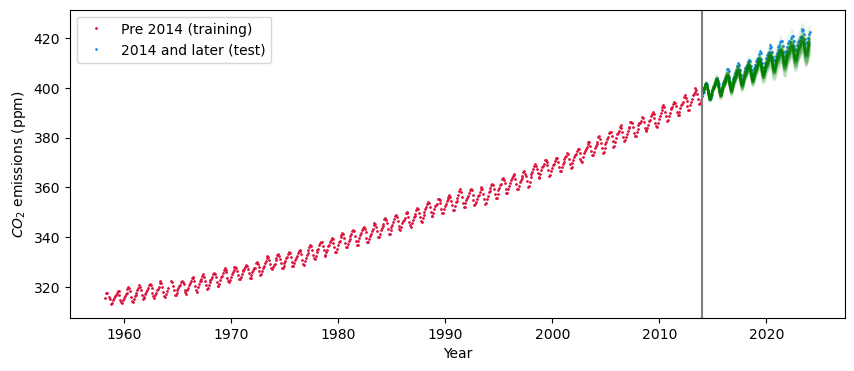

In [180]:
fig = plt.figure(figsize=(10,4))
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.plot(xnew,fstar.T,'g',alpha=0.1)
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.show()

## References

List of references:

1) AE8803 class webpage "GP 101". https://psesh.github.io/ae8803/useful_codes/gp101.html
2) Gradient Descent Algorithm for a non-linear system: https://en.wikipedia.org/wiki/Gradient_descent#Solution_of_a_non-linear_system
3) Gradient Descent Using Python and Numpy (as an example): https://stackoverflow.com/questions/17784587/gradient-descent-using-python-and-numpy
4) Calculating the Trace of the inverse of a PD matrix - used for $\frac{\partial}{\partial \theta_j} log p(y|X,\theta)$, when calculating values involved with gradient descent. https://math.stackexchange.com/questions/391128/trace-of-an-inverse-matrix
5) Cholesky Decomposition (can probably find algorithm in RW, or note that there is one that numpy uses)
6) AE8803 class webpage "Gaussian Marginals and Conditionals". https://psesh.github.io/ae8803/useful_codes/gaussians.html
7) Mauna Loa Atmospheric Carbon Dioxide example in Rasmussen and Williams book: section 5.3.4, page 118.
8) Predictive Posterior computational algorithm. Rasmussen & Williams, pg 19
9) AE8803, Lecture 12 - "Hyperparameter Inference" for the MAP equations
10) Rasmussen and Williams, partial derivatives of the log of hyperparameter likelihood function. Equation (5.9), page 114.

## Begin Coding

In the following code, we have borrowed substantial coding infrastructure from the webpage "GP 101" [1].

In [45]:
# allowed libraries: numpy, seaborn, matplotlib, scipy, pandas

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky, solve_triangular
import seaborn as sns
sns.set_theme(font_scale=1.0)
sns.set_style("white")
sns.set_style("ticks")
palette = sns.color_palette('deep')

In [46]:
# define the size of the training data set
N = df2014.shape[0]

The three code blocks below define the kernel, a utility function for *tiling*, and the posterior calculation. To clarify, this is the predictive posterior distribution evaluated at some *test* locations, $\mathbf{X}_{\ast}$. The expression for both the predictive posterior mean and covariance are given by:

$$
\begin{aligned}
\mathbb{E} \left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{y} \\
Covar\left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X}_{\ast} \right) - \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{K}\left( \mathbf{X}, \mathbf{X}{\ast} \right)
\end{aligned}
$$

In [47]:
def kernel(xa, xb, amp, ll):
    Xa, Xb = get_tiled(xa, xb)
    return amp**2 * np.exp(-0.5 * 1./ll**2 * (Xa - Xb)**2 )

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

def get_posterior(amp, ll, x, x_data, y_data, noise):
    u = y_data.shape[0]
    mu_y = np.mean(y_data)
    y = (y_data - mu_y).reshape(u,1)
    Sigma = noise * np.eye(u)
    
    Kxx = kernel(x_data, x_data, amp, ll)
    Kxpx = kernel(x, x_data, amp, ll)
    Kxpxp = kernel(x, x, amp, ll)
    
    # Inverse
    jitter = np.eye(u) * 1e-12
    L = cholesky(Kxx + Sigma + jitter)
    S1 = solve_triangular(L.T, y, lower=True)
    S2 = solve_triangular(L.T, Kxpx.T, lower=True).T
    
    mu = S2 @ S1  + mu_y
    cov = Kxpxp - S2 @ S2.T
    return mu, cov

In [49]:
Xt = dfnew['Date'].values # test data locations (Date)

# Hyperparameters (note these are not optimized!)
length_scale = 7.0
amplitude = 0.8


noise_variance = 0.1
mu, cov = get_posterior(amplitude, length_scale, Xt, df2014['Date'].values, df2014['CO2'].values, noise_variance)

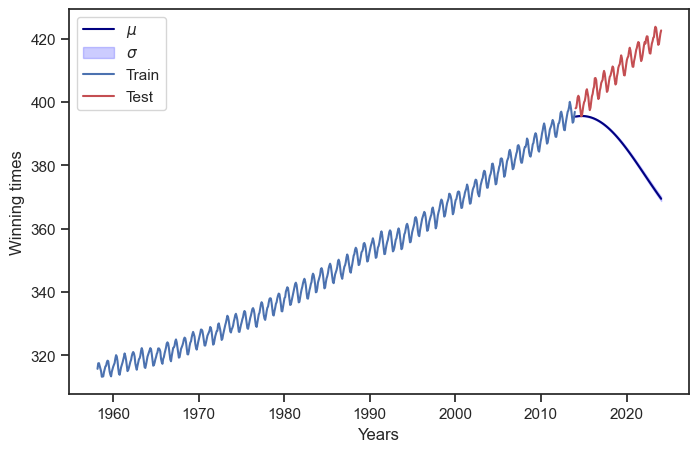

In [54]:
Xt = Xt.flatten()
mu = mu.flatten() 
std = np.sqrt(np.diag(cov)).flatten()

fig = plt.figure(figsize=(8, 5))
plt.plot(Xt, mu, '-', label=r'$\mu$', color='navy')
plt.fill_between(Xt, mu+std, mu-std, color='blue', alpha=0.2, label=r'$\sigma$')
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'b', label='Train', ms=8)
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'r', label='Test')
plt.xlabel('Years')
plt.ylabel('Winning times')
plt.legend()
plt.show()